## different by splitting to train test valid (here valid and test are switched)

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from dataset_loader import *
from utils import *
from datasets import Dataset, DatasetDict
import datasets
import logging
import warnings
from retrain_utils import *
logging.disable(logging.WARNING) 
datasets.set_progress_bar_enabled(False)
warnings.simplefilter("ignore")

SEED = 84
torch.manual_seed(SEED)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [20]:
dataset_name = 'sentiment'
ds = get_ds(dataset_name)

In [11]:
model_name =  'huawei-noah/TinyBERT_General_4L_312D'
folder_name = 'gru'

In [ ]:
retrain_utils = RetrainUtils(model_name, dataset_name, folder_name)
added_train = retrain_utils.replace_sentences(ds['train'].to_pandas(), RetrainAction.ADD)
removed_train = retrain_utils.replace_sentences(ds['train'].to_pandas(), RetrainAction.REMOVE)
replaced_train = retrain_utils.replace_sentences(ds['train'].to_pandas(), RetrainAction.REPLACE)

In [ ]:
ds['train'] = removed_train

In [ ]:
# 50 padding for sentiment, 64 for corona
set_seed()    
model = MyGRU(model_name, hidden_dim=256, num_layers=2, output_dim=2, dropout=0.0)
tokenized_data = tokenize_dataset(ds, tokenizer_name=model_name, max_length = 64)
_ = train(model, tokenized_data, path=f'{folder_name}/{dataset_name}/check', num_train_epochs=20)

In [ ]:
torch.save(model.state_dict(), f'{folder_name}/{dataset_name}/retrained_model/pytorch_model.bin')

### saved best model's folder as 'retrained'

In [17]:
retrained_model = load_model(f'{folder_name}/{dataset_name}/retrained_model').to(device).eval()
orig_model = load_model(f'{folder_name}/{dataset_name}/model').to(device).eval()
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [18]:
tokenized_data = tokenize_dataset(ds, tokenizer_name=model_name, max_length = 64)
train(orig_model, tokenized_data, path=f'{folder_name}/{dataset_name}', evaluate = True)['eval_accuracy']

0.8576555023923444

# GRU

## Corona

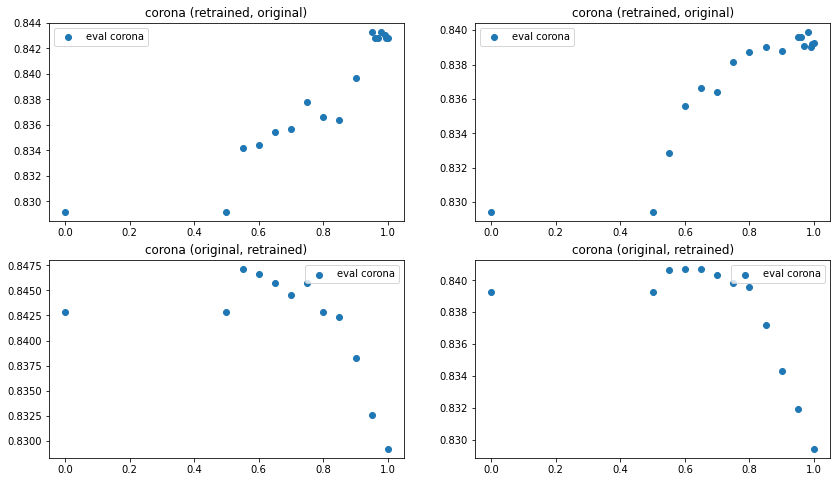

In [19]:
ds = get_ds('corona')
ensemble_results(folder_name, model_name, 'corona', 'corona', ds['val'], ds['test'], 'retrained_model', 'model')

## Sentiment

In [ ]:
ds = get_ds('sentiment')
ensemble_results(folder_name, model_name, 'sentiment', 'sentiment', ds['val'], ds['test'], 'retrained_model', 'model')

In [13]:
predicting_sentences(model, tokenizer, device, [tokenizer.tokenize("i love movies")])

tensor([[ 1.7911, -1.7094]], device='cuda:0', grad_fn=<AddmmBackward0>)


array([0])

In [14]:
predicting_sentences(model, tokenizer, device, [tokenizer.tokenize("i hate movies")])

tensor([[-2.3436,  2.2181]], device='cuda:0', grad_fn=<AddmmBackward0>)


array([1])